# Klasyfikator znaków drogowych
Celem ćwiczenia jest budowa prostego klasyfikatora znaków drogowych z wykorzystniem konwolucyjnych sieci neuronowych. Klasyfikator umożliwi rozpoznawanie 43 różnych znaków drogowych.
Do realizacji zadania zostanie wykorzystna biblioteka [Keras](https://keras.io) oraz [TensorFlow](https://www.tensorflow.org) umożliwiające szybkie i łatwe tworzenie, uczenie i testowanie sieci neuronowych. 

# Pobieranie danych
Do nauki sieci wykorzystany zostanie przykładowy zbiór zdjęć znaków drogowych.

Zbiór znaków można pobrać z adresu [https://bitbucket.org/jadslim/german-traffic-signs](https://bitbucket.org/jadslim/german-traffic-signs)
Zbiór danych zawiera różne zdjęcia znaków drogowych podzielno na trzy podzbiory: dane uczące, walidacyjne i do testowania. Zaletą pobranego zbioru danych jest to, że każde zdjęcie przedstawiające znak drogowy zostało również prawidłowo opisane poprzez podanie jakie rodzaju znaku zawiera.

W środowisku Google Colaboratory można wykonywać instrukcje powłoki (np. `ls`, `mkdir`) poprzedzając komendy znakiem wykrzyknika - **`!`.**

In [2]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [3]:
!ls german-traffic-signs -lh

'ls' is not recognized as an internal or external command,
operable program or batch file.


# Import bibliotek


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import pickle
import pandas as pd
import cv2
import requests
from PIL import Image

from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
 
%matplotlib inline
np.random.seed(0)

# Przygotowanie danych

Do nauki sieci neuronowych wykorzystywane są trzy zbiory danych:
* zbiór danych uczących
* zbiór danych walidacyjnych
* zbiór danych testowych

Spośród tych trzech zbiorów, najliczniejszy powinien być zbiór danych uczących. Należy również zadbać o to aby był on najbardziej reprezentatywny tj. zawierał wszystkie możliwe obrazki które zawierają cechy które chcemy rozpoznawać i klasyfikować za pomocą sieci neuronowej. Również, wszystkie rodzaje znaków które chcemy rozpoznawać za pomocą sieci neuronowej powinny być reprezentowane przez w miarę taką samą liczbę zdjęć.

Należy zawsze pamiętać iż sieć neuronowa działa tak dobrze jakimi danymi została wytrenowana.

Poniższy kod wczytuje zdjęcia znaków z poszczególnych plików oraz deserializuje je do pojedyńczych obrazków tak aby mogły zostać dalej wykorzystane.


In [7]:
# Train data
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)

# Valid data
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

# Test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

# Signname
sign_name = pd.read_csv('german-traffic-signs/signnames.csv')

Wczytane dane do zmiennych `traind_data`, `val_data`, `test_data` - są typu słownikowego (ang. dictionary) które zawierając następujące klucze:
* `feature` - zdjęcie znaku
* `labels` - numer typu znaku który odpowiada jego nazwie zapisanej w pliku signnames.cs.

Wywołanie komendy `print(X_train.shape)` zwraca wymiary tablicy jaka została utworzona z wczytanych danych. W naszym przypadku dla zmiennej `X_train` widzimy, że zawiera ona 34799 elementów którymi są tablice o wymiarach 32x32 i trzech kanałach. Rozmiary poszczególnych tablic wynikają z rozmiarów zdjęć znaków (32x32 piksele) oraz tego, że są one kolorowe (zawierają trzy kanały kolorów RGB). 



In [8]:
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

#already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)
(34799,)


## Sprawdzenie poprawności danych

Jedną z dobrych praktyk jest sprawdzanie czy dane które będziemy wykorzystywać w dalszej części prac mają poprawne rozmiary. Można to zrealizować np. z pomocą funkcji [`assert`](https://www.tutorialspoint.com/python/assertions_in_python.htm).

In [9]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

## Analiza wczytanych danych
Poniższy kod wyświetla po 5 losowych znaków z każdego typu znaków. 

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


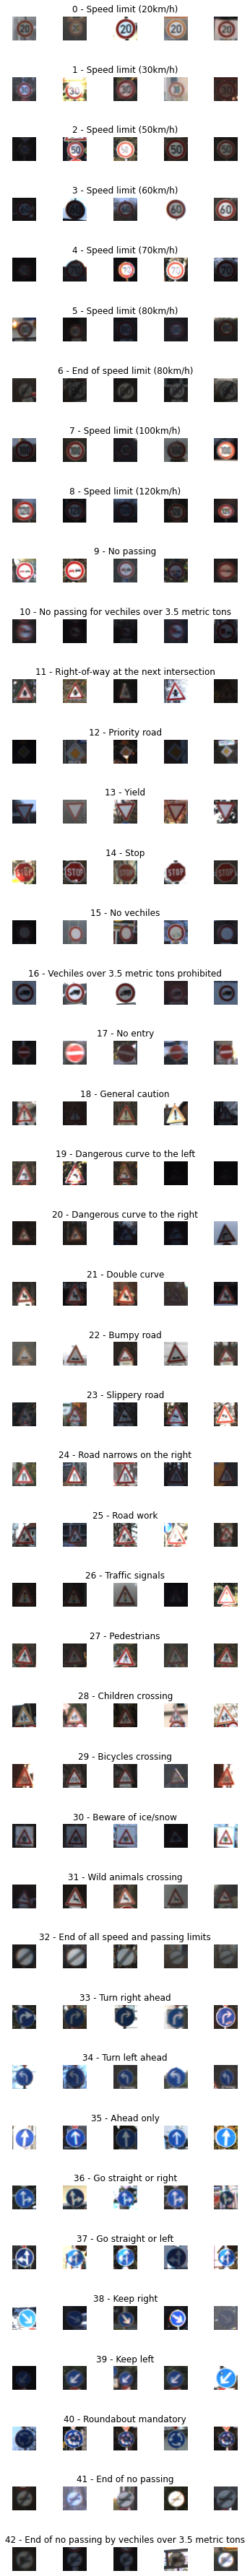

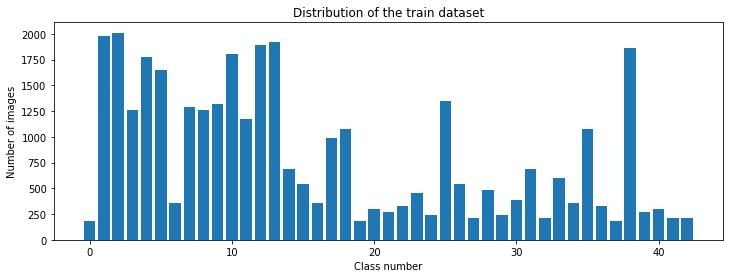

In [10]:
# Tabeli przechowuje liczbe znakow z kazdego typu  
num_of_samples = []
 
cols = 5

# Liczba rodziajów znaków
num_classes = sign_name.shape[0]
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
  for j, row in sign_name.iterrows():
    # Z zbioru treningowego wybieramy te znaki które są sklasyfikowane jako j-typ znaku
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + " - " + row["SignName"])
      num_of_samples.append(len(x_selected))

print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

**Zadanie**
Napisz kod który wyświetla losowy wybrany znak ze zbioru uczącego wraz z jego typem.

In [8]:
# DONE
def random_sign_display():
    random_sign_number = np.random.randint(0, X_train.shape[0])
    x = 0
    for number, row in sign_name.iterrows():
      if number == y_train[random_sign_number]:
        x = row["SignName"]
        break
    title = str(y_train[random_sign_number]) + " - " + str(x) 
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.imshow(X_train[random_sign_number])
    plt.show()

(34799, 32, 32, 3)


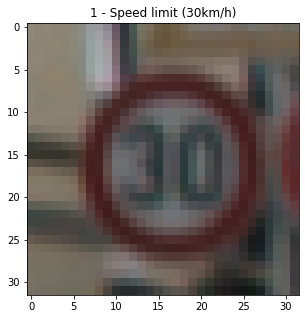

(34799, 32, 32, 3)


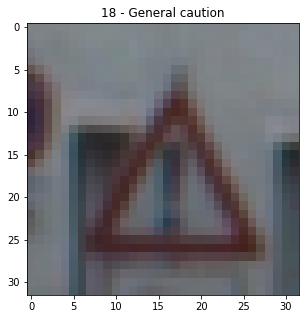

(34799, 32, 32, 3)


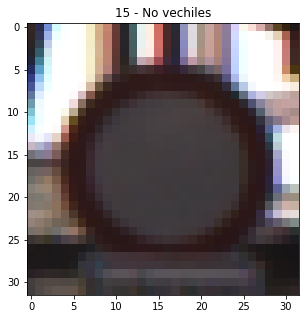

(34799, 32, 32, 3)


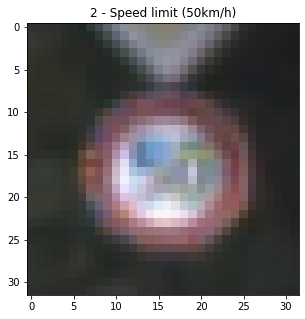

(34799, 32, 32, 3)


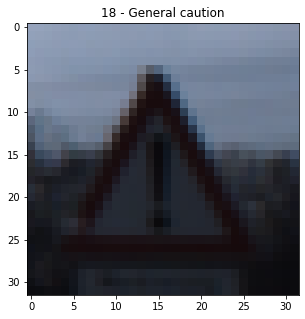

(34799, 32, 32, 3)


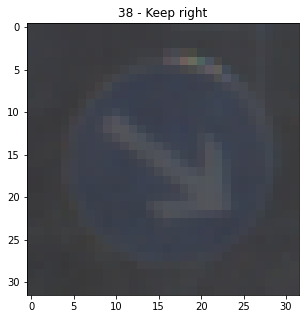

(34799, 32, 32, 3)


(34799, 32, 32, 3)


(34799, 32, 32, 3)


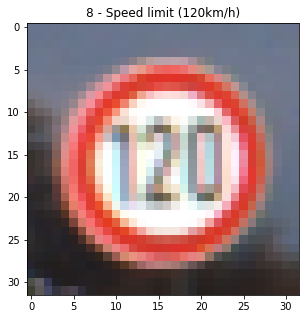

(34799, 32, 32, 3)


In [9]:
loop = 10
for i in range(loop) :
    print(X_train.shape)
    random_sign_display()

Jak można zaobserować zbiór uczący zawiera zdjęcia znaków wykonane w różnych warunkach np. zmienne oświetelenie. W celu bardziej efektywnego wykorzystania danych do uczenia się sieci poszczególne zdjęcia powinny zostać podane dodatkowej obróbce, tak aby zminimalizować wpływ warunków zewnętrznych w jakich zostały zrealizowane a równocześnie uwypuklić cech charaktyrystyczne znaków - tak aby finalnie sieć nauczyła się rozpznawać typu znaków poprawnie.

Jednym z parametrów zdjęcia czułym na warunki zewnętrzne jest np. kolor. Zdjęcie znaku wykonane przy niewystarczającym oświetleniu jest ciemnie i informacja o kolorze jest mało wiarygodna. Z tego też powodu pierwszą operacją będzie konwersja zdjęć do zdjęć monochromatycznych. Dodatkowo konwersja zdjęć kolorowych do postaci monochromatycznej umożliwa zredukowanie wymiaru danych poszczególnych zdjęć z 32x32x3 na 32x32x1.

Główną cechą znaków drogowych są ich kształty oraz krzywe dlatego też sieć neuronowa powinna "nauczyć" sie przede wszystkim rozpoznawania tych cech.

Kolejną operacją jaką poddamy zdjęcia znaków będzie zwiększenie ich kontrastu za pomocą metody [wyrówniania histogramu](https://pl.wikipedia.org/wiki/Wyr%C3%B3wnanie_histogramu).

Poniższy kod można wykonać kilkukrotnie tak aby zaobserwować ja działają filtry na zdjęcia znaków wykonane w różnych warunkach.

In [80]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

sign_index = random.randint(0, X_train.shape[0] - 1)

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(X_train[sign_index])
plt.title("Oryginal image")
plt.axis("off")

def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[sign_index])
plt.subplot(132)
plt.imshow(img, cmap='gray')
plt.title("Grayscale")
plt.axis("off")
print("Grayscale shape image: " + str(img.shape))

def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.subplot(133)
plt.imshow(img)
plt.title('Equalize')
plt.axis("off")
print("Equalize shape image: " + str(img.shape))


def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

# Zastosowany filtrów obrazów do wszystich danych
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

Grayscale shape image: (32, 32)
Equalize shape image: (32, 32)


In [81]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 1)

y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

# Sieć neuronowa

## Architektura sieci

Poniższe dwie funkcje definują dwie sieci o różnej budowie. Sieć zdefiniowana przez funkcję `model_v1` jest siecią prostszą (mniej warstw i parametrów), natomiast sieć `model_v2` jest siecią bardziej rozbudowaną.

In [82]:
# create model v1
def model_v1():
  model = Sequential()

  model.add(Conv2D(30, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(15, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  
  model.compile(Adam(learning_rate = 0.01), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# create model v2
def model_v2():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  
  model.compile(Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Wybraną sieć tworzymy wywołując odpowiednią funkcję która ją buduje. Parametry sieci, szczegóły jej budowy możemy odczytać za pomocą funkcji `model.summary()`.

In [83]:
model1 = model_v1()

In [84]:
model2 = model_v2()

## Uczenie sieci

In [85]:
history1 = model1.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
87/87 [==============================] - 9s 95ms/step - loss: 2.3979 - accuracy: 0.3442 - val_loss: 0.9697 - val_accuracy: 0.6912
Epoch 2/10
87/87 [==============================] - 8s 91ms/step - loss: 0.7964 - accuracy: 0.7420 - val_loss: 0.6719 - val_accuracy: 0.7889
Epoch 3/10
87/87 [==============================] - 8s 91ms/step - loss: 0.5332 - accuracy: 0.8259 - val_loss: 0.5193 - val_accuracy: 0.8483
Epoch 4/10
87/87 [==============================] - 8s 91ms/step - loss: 0.4237 - accuracy: 0.8642 - val_loss: 0.5409 - val_accuracy: 0.8410
Epoch 5/10
87/87 [==============================] - 8s 92ms/step - loss: 0.3627 - accuracy: 0.8838 - val_loss: 0.4918 - val_accuracy: 0.8635
Epoch 6/10
87/87 [==============================] - 8s 94ms/step - loss: 0.3118 - accuracy: 0.8994 - val_loss: 0.4392 - val_accuracy: 0.8766
Epoch 7/10
87/87 [==============================] - 8s 93ms/step - loss: 0.2806 - accuracy: 0.9076 - val_loss: 0.4982 - val_accuracy: 0.8660
Epoch 8/10
87

In [86]:
history2 =  model2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
87/87 [==============================] - 73s 829ms/step - loss: 2.0723 - accuracy: 0.4406 - val_loss: 0.5839 - val_accuracy: 0.8195
Epoch 2/10
87/87 [==============================] - 70s 805ms/step - loss: 0.4492 - accuracy: 0.8637 - val_loss: 0.2817 - val_accuracy: 0.9204
Epoch 3/10
87/87 [==============================] - 70s 801ms/step - loss: 0.2080 - accuracy: 0.9361 - val_loss: 0.2152 - val_accuracy: 0.9435
Epoch 4/10
87/87 [==============================] - 69s 798ms/step - loss: 0.1281 - accuracy: 0.9602 - val_loss: 0.1661 - val_accuracy: 0.9524
Epoch 5/10
87/87 [==============================] - 70s 801ms/step - loss: 0.0827 - accuracy: 0.9750 - val_loss: 0.1533 - val_accuracy: 0.9574
Epoch 6/10
87/87 [==============================] - 69s 798ms/step - loss: 0.0666 - accuracy: 0.9793 - val_loss: 0.1084 - val_accuracy: 0.9712
Epoch 7/10
87/87 [==============================] - 70s 803ms/step - loss: 0.0551 - accuracy: 0.9827 - val_loss: 0.1124 - val_accuracy: 0.9658

## Analiza działania sieci

W wynikiem wywołania metody `fit` jest obiekt klasty `History` który zawiera różne dane opisujące jak dokładnie działa wytrenowana siec.

Wykres pierwszy ("Loss") przedstawia wartość błędu sieci neurnowej w poszczególnych iteracjach trenowania. Wartością porządaną jest aby błąd ten miał jak najmniejszą wartość.

Wykres drugi ("Accuracy") przedstawia dokładność sieci neurnowen w poszczególnych iteracach uczenia się sieci. Wartością porządaną jest aby dokładność miała wartość jak najbardziej zbliżoną do 1.0.

In [87]:
def print_res(history, title='') :
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.suptitle(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['loss','val_los'])
    plt.title('Loss')
    plt.xlabel('epoch')

    plt.subplot(122)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['training','test'])
    plt.title('Accuracy')
    plt.xlabel('epoch')

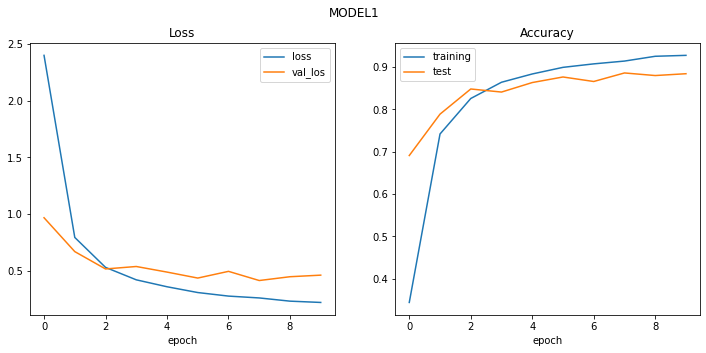

In [88]:
print_res(history1, 'MODEL1')

In [89]:
print_res(history2, 'MODEL2')

In [90]:
def print_score(model, title='') :
    print(title)
    score = model.evaluate(X_test, y_test, verbose=1)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

In [91]:
print_score(model1, 'MODEL1')

MODEL1
395/395 [==============================] - 2s 4ms/step - loss: 0.5547 - accuracy: 0.8744
Test score: 0.554685115814209
Test accuracy: 0.8744259476661682


In [92]:
print_score(model2, 'MODEL2')

MODEL2
395/395 [==============================] - 8s 20ms/step - loss: 0.2110 - accuracy: 0.9499
Test score: 0.21104052662849426
Test accuracy: 0.9498812556266785


Nauczona sieć neuronowa może być równiez testowana za pomocą różny zdjęć znaków tak jak to pokazano na poniższym przykładzie.

In [93]:
# predict internet number
url_list = [
  'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg',
  'https://previews.123rf.com/images/nito500/nito5001603/nito500160300136/54039163-a-triangular-traffic-sign-with-an-exclamation-mark-against-the-blue-sky.jpg',
  'https://previews.123rf.com/images/djdarkflower/djdarkflower1512/djdarkflower151200007/50042106-slippery-road-vector-sign.jpg',
  'https://previews.123rf.com/images/albasu/albasu1610/albasu161000422/64990426-warning-or-red-attention-elephants.jpg',
  'https://previews.123rf.com/images/majestix77/majestix771903/majestix77190300647/132519768-winter-driving-warning-sign-risk-of-snow-and-ice.jpg',
  'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg',
  'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg',
  'https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg',
  'https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg',
  'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
]

def rec_img(model, ulr_list) :
  for num, url in enumerate(url_list):
    r = requests.get(url, stream=True)
    img1 = Image.open(r.raw)
    
    # Przygotowanie pobranego zdjęcia znaku drogowego do rozpoznania
    img_rec = np.asarray(img1)
    img_rec = cv2.resize(img_rec, (32, 32))
    img_rec = preprocess(img_rec)
    img2 = img_rec
  
    # Rozpoznanie znaku przez sieć neuronową
    img_rec = img_rec.reshape(1, 32, 32, 1)
    road_sign_type = np.argmax(model.predict(img_rec), axis=-1)
    
    fig , [ax1, ax2] = plt.subplots(1, 2)
    fig.set_size_inches([12, 6])
    fig.suptitle(str(num) + ". predicted sign: "+ str(road_sign_type[0]) + "; name: " + sign_name['SignName'][road_sign_type[0]])
    ax1.imshow(img1)
    ax1.set_title("Original Image")
    ax2.imshow(img2)
    ax2.set_title("Converted Image")

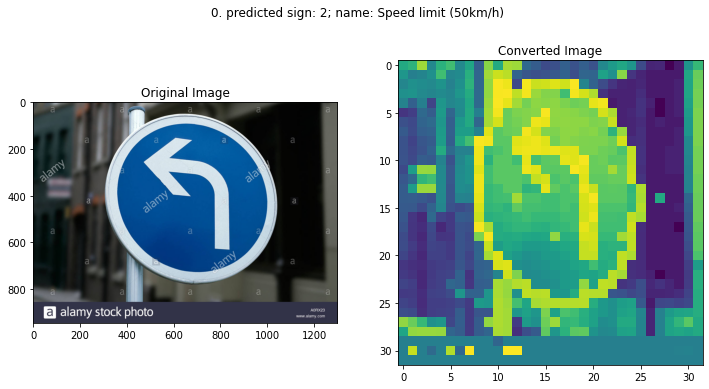

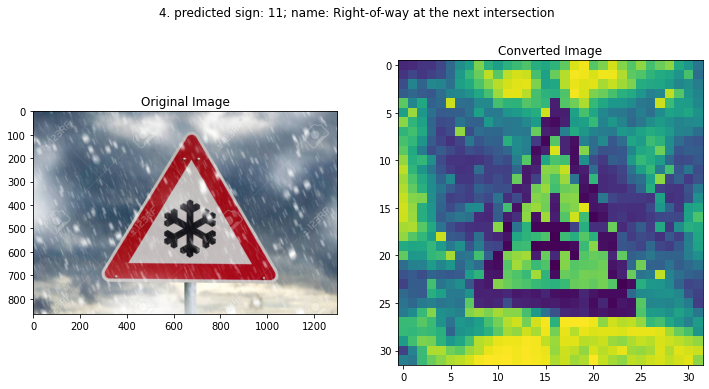

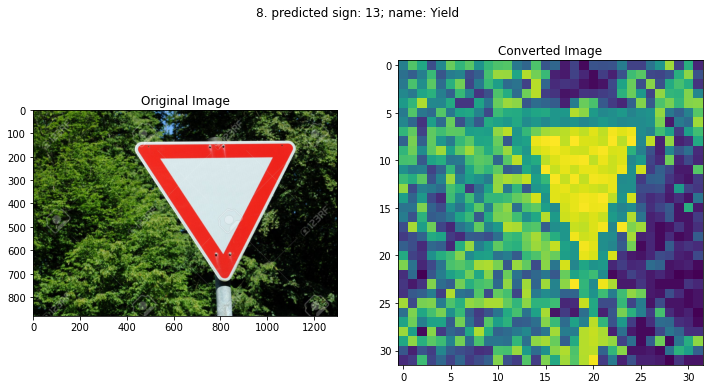

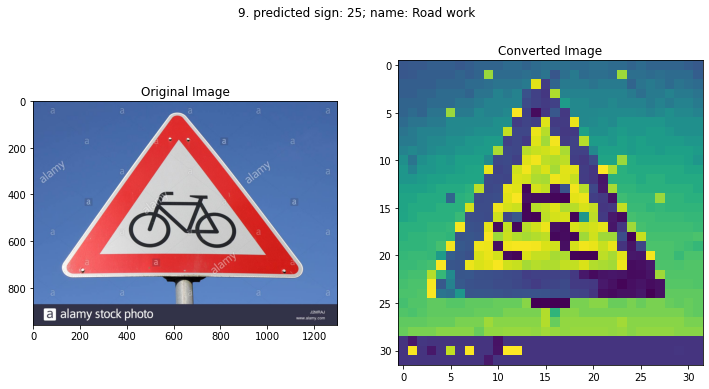

In [94]:
rec_img(model1, url_list)

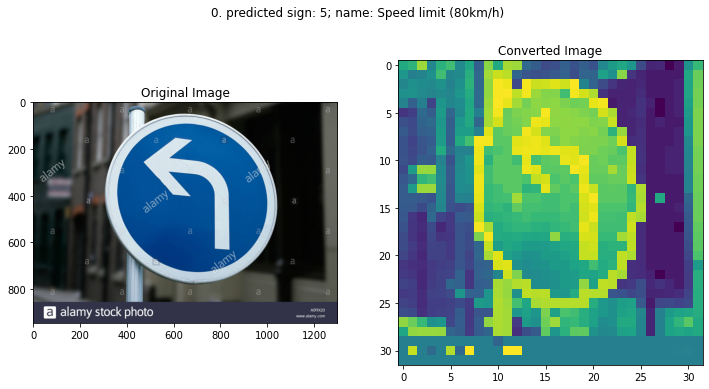

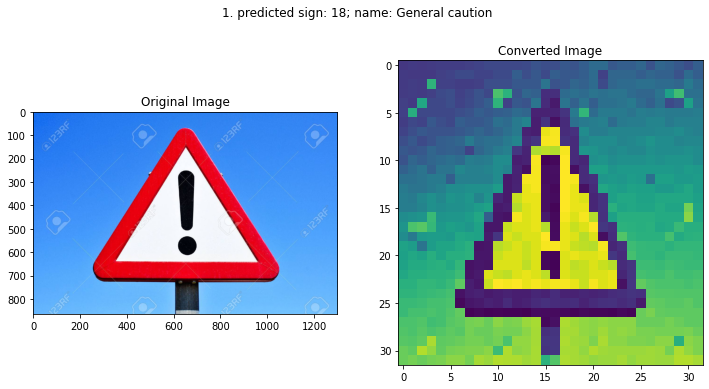

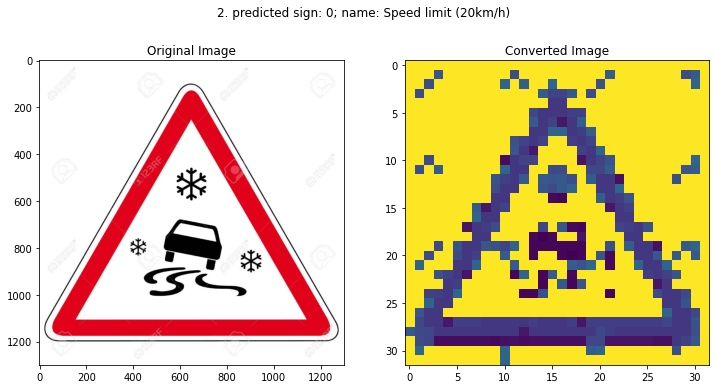

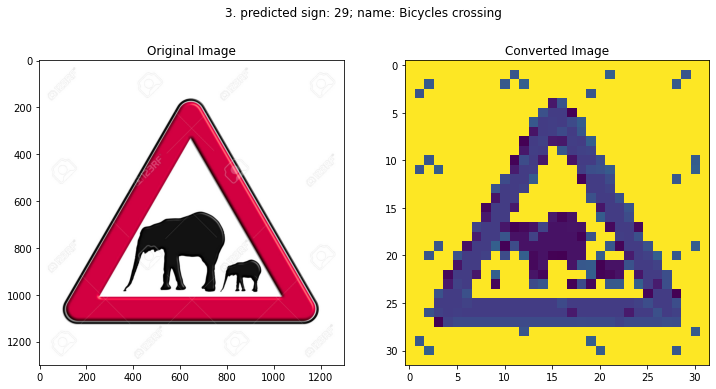

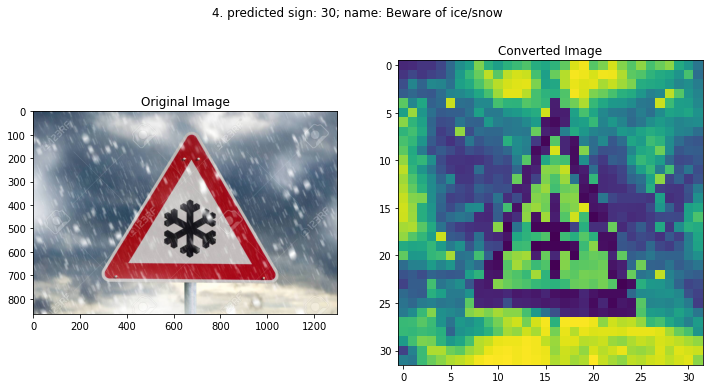

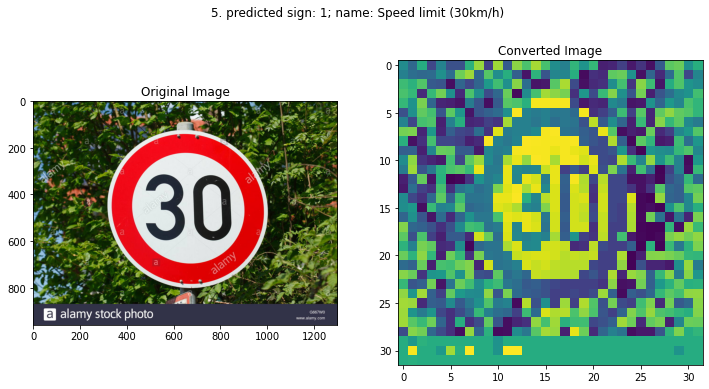

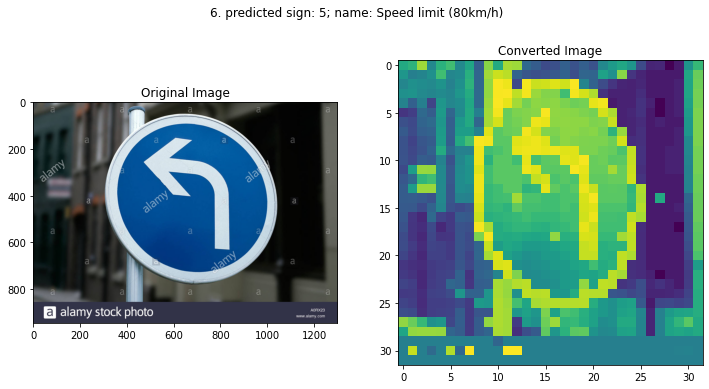

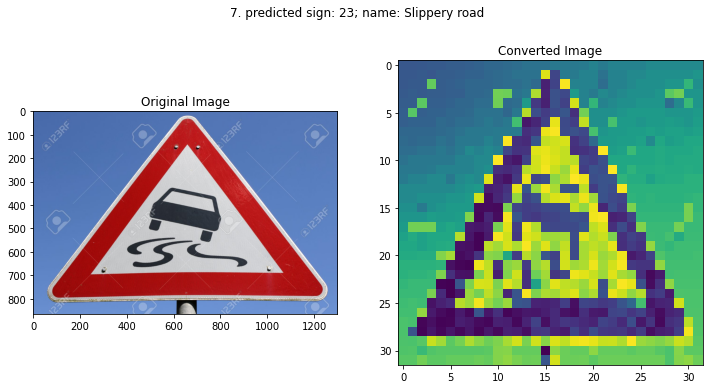

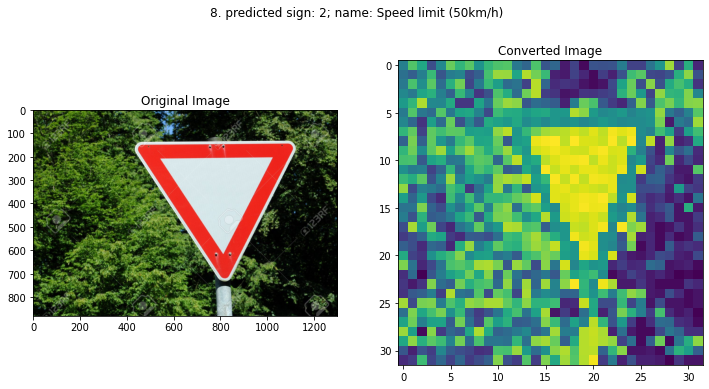

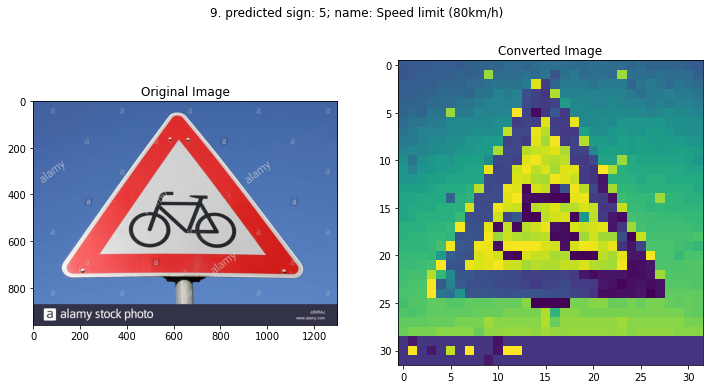

In [95]:
rec_img(model2, url_list)